# Edge dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sys import getsizeof
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
import os
import time
path="/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/"
datapath="/its/home/drs25/Documents/data/Tactile Dataset/datasets/"
if os.name == 'nt':
    path="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/"
    datapath="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/texture-tactip/"

#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:18230"

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device=torch.device("cpu")
print(f"Using device: {device}")


Using device: cpu


(1080, 100, 100) (1080,)


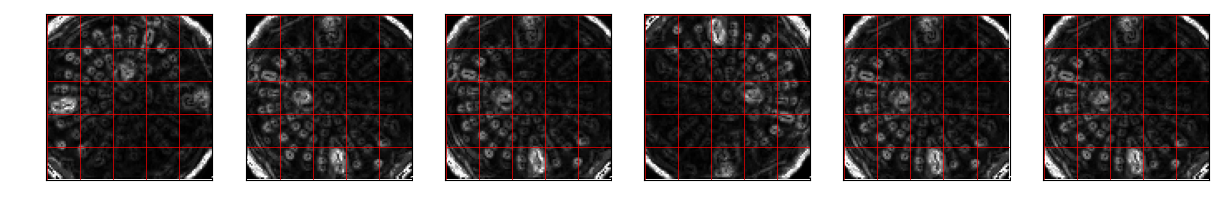

In [94]:
#load in dataset as compressed numpy (for storage) 
X_=np.load(datapath+"X_edge.npz")
for array_name in X_:
    X=X_[array_name].astype(np.uint8)
y_=np.load(datapath+"y_edge.npz")
for array_name in y_:
    y=y_[array_name].astype(np.uint8)

#relabel
y[y==7]=20 #20 degrees
y[y==4]=40 
y[y==11]=60 
#y[y==10]=240 
virginX=X.copy()
y_prime=np.zeros((len(y)*len(X[1])))
X_prime=np.zeros((len(X)*10,X.shape[2],X.shape[3]))
k=0
for i in range(len(X)): #create data aas linear images
    for j in range(len(X[0])):
        y_prime[k]=y[i]
        X_prime[k]=X[i][j]
        k+=1
X=X_prime
y=y_prime
X=X[:,10:110,10:110]
def applySobel(X):
    for i in range(len(X)): #crop all images individually
        image=X[i]
        # Apply Sobel filter in x-direction
        sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

        # Apply Sobel filter in y-direction
        sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

        # Convert the results back to uint8
        sobel_x = np.uint8(np.absolute(sobel_x))
        sobel_y = np.uint8(np.absolute(sobel_y))

        # Combine the results to get the final edge-detected image
        sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
        X[i]=sobel_combined

def augment(X,y):
    #create rotations
    AugmentedX=np.zeros((len(X)*3,*X.shape[1:]),dtype=np.uint8)
    Augmentedy=np.zeros_like(np.concatenate((y,y,y)))
    for k,i in enumerate(range(0,len(AugmentedX),3)): #loop through the normal data and new data
        AugmentedX[i]=np.copy(X[k])
        AugmentedX[i+1]=cv2.resize(cv2.rotate(X[k].copy(), cv2.ROTATE_90_CLOCKWISE),(X[k].shape[1],X[k].shape[0]),interpolation=cv2.INTER_AREA)
        AugmentedX[i+2]=cv2.resize(cv2.rotate(X[k].copy(), cv2.ROTATE_180),(X[k].shape[1],X[k].shape[0]),interpolation=cv2.INTER_AREA)
        Augmentedy[i+1]=y[k]+90
        Augmentedy[i+2]=y[k]+180
        Augmentedy[i]=y[k]
    #randomize order
    n_samples = AugmentedX.shape[0]
    indices = np.random.permutation(n_samples)
    shuffled_data = AugmentedX[indices]
    shuffled_labels = Augmentedy[indices]
    X=shuffled_data
    y=shuffled_labels
    return X,y
X,y=augment(X,y)
applySobel(X)
fig, axes = plt.subplots(1, 6, figsize=(15, 10))
axes = axes.flatten()
print(X.shape,y.shape)
for i in range(6):
    im=axes[i].imshow(X[i],cmap="gray")
    #axes[i].axis("off")
    axes[i].set_xticks(np.arange(0, 110, 20))
    # Set custom ticks for y-axis (every 10 units)
    axes[i].set_yticks(np.arange(0, 110, 20))
    axes[i].tick_params(axis='x', colors='white')
    axes[i].tick_params(axis='y', colors='white')
    axes[i].grid(True, which='both', axis='both', color='r', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/edgeExamplesAugmented.pdf")
plt.show()

## MOdelling

In [92]:
encoder = OneHotEncoder()  # sparse_output=False returns a dense array
# Fit and transform the label data
onehot_labels = encoder.fit_transform(y.reshape(-1, 1))
X_=X.reshape(len(X),-1)
print(np.unique(y))
X_train, X_test, y_train, y_test = train_test_split(X_, np.argmax(onehot_labels,axis=1).astype(np.uint8), test_size=0.2, random_state=42)
print(X_train.shape,y_train.shape)
# Standardize the features (important for SVM)
"""scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)"""

# Create an SVM classifier
svm_model = SVC(decision_function_shape='ovo')

# Train the SVM model
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)
y_pred2 = svm_model.predict(X_train)

y_pred = svm_model.predict(X_test)
y_pred2 = svm_model.predict(X_train)
loss=np.abs(y_pred2.reshape((y_pred2.shape[0],1))-y_train)
loss[loss>0]=1
correct=len(loss)-np.sum(loss)
print("Accuracy train:",correct/len(loss))

loss=np.abs(y_pred.reshape((y_pred.shape[0],1))-y_test)
loss[loss>0]=1
correct=len(loss)-np.sum(loss)
print("Accuracy test:",correct/len(loss))

[20. 40. 60.]
(288, 10000) (288, 1)


/its/home/drs25/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy train: 1.0
Accuracy test: 1.0


(3, 3) 72 72


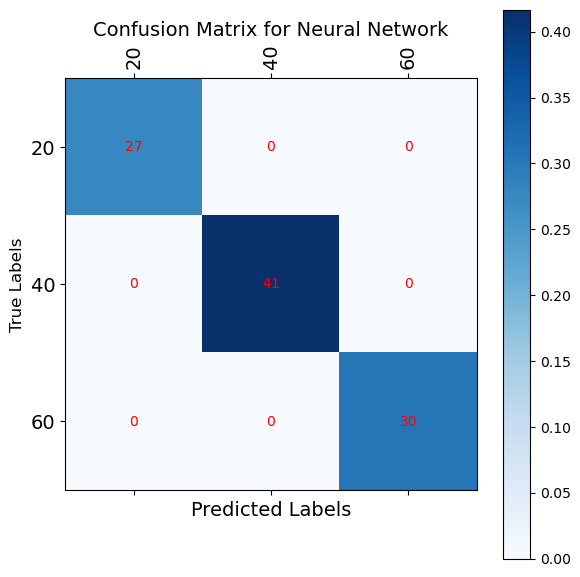

In [93]:
def compute_confusion_matrix(true_labels, pred_labels, num_classes):
    matrix = np.zeros((num_classes, num_classes), dtype=int)
    un=np.unique(y_train,axis=0)
    print(matrix.shape,len(true_labels),len(pred_labels))
    for t, p in zip(true_labels, pred_labels):
        matrix[t, p] += 1
    return matrix/len(true_labels)

predictions = [y_pred]
model_names = ['Neural Network']
num_classes = len(np.unique(y_train,axis=0))
un=np.unique(y_train,axis=0)
indices = np.arange(num_classes)
# Plotting confusion matrices for each model
fig, axes = plt.subplots(1, len(predictions), figsize=(6, 6))
labels=[ "20",  "40",  "60", "110", "130", "150", "200", "220", "240"]
for i, preds in enumerate(predictions):
    cm = compute_confusion_matrix(y_pred, y_test, num_classes=len(np.unique(y_train,axis=0)))
    
    ax = axes[i] if len(predictions) > 1 else axes
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax, ax=ax)
    
    for (j, k), value in np.ndenumerate(cm):
        ax.text(k, j, f'{int(value*100)}', ha='center', va='center', color='red')
    ax.set_title(f'Confusion Matrix for {model_names[i]}',fontsize=14)
    ax.set_xlabel('Predicted Labels',fontsize=14)
    ax.set_xticks(indices)
    ax.set_xticklabels([labels[un[j][0]] for j in range(num_classes)],rotation=90,fontsize=14)
    ax.set_ylabel('True Labels',fontsize=12)
    ax.set_yticks(indices)
    ax.set_yticklabels([labels[un[j][0]] for j in range(num_classes)],rotation=0,fontsize=14)

plt.tight_layout()

plt.show()